<img style="width:20%;float: left; margin-right: 10px;" src="https://upload.wikimedia.org/wikipedia/en/a/ae/CERN_logo.svg"/>



#    2D images classification using Machine Leaning for brain tumors

## Introduction
Brain tumors are considered by the medical community as an aggressive and difficult to treat disease that affects adults and children.

The most common primary brain tumors are gliomas, meningiomas, and pituitary.

Gliomas are the most common type of brain tumor in adults. It is about 78 percent of malignant brain tumors according to the American Association of Neurological Surgeons. <a href="#1"> [1] </a>

In this tutorial we are going to classify 2D images with machine learning, for tumors such as **meningioma**, **glioma**, **pituitary** and people **without tumors**.

As mentioned in the preprocessing notebook, we are using  a public data set, taken from
kaggle <a href="#2"> [2] </a>, with 2D MRI images.

## About ML for Brain Tumor Classification

The classification of brain tumors is a complex task, it requires sophisticated machine learning and mathematical models, we are using the latest in the state of the art for image processing such as convolutional neural networks <a href="#3"> [3] </a>.

It also requires elaborate techniques to preprocess the images, such as skull stripping <a href="#4"> [4] </a>, advanced tools for data normalization such as Ants <a href="#5"> [5] </a>, tools for image transformation such as
scikit-image <a href="#6"> [6] </a> or open computer vision library (open-cv) <a href="#7"> [7] </a>

This tutorial is done using Tensorflow with Keras <a href="#8"> [8] </a> and due to limited resources, we will run a binary classifier using 64x64 pixel 2D images.


<hr>

# Let's get started!

The first step is to import the necessary modules. Those modules are for handling numerical matrices, plotting, creating the machine learning model and calculating some statistics about the results.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam #http://arxiv.org/abs/1412.6980
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, Dropout,BatchNormalization,Activation,SpatialDropout2D
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Defining and Select the categories

The second step is to define the categories for our problem, in our case it is an array of four labels for meningioma, glioma, pituitary tumors and no tumors.

We have to select two of those categories to perform the binary classification, initially, we will take **no tumor** and **glioma**.

In [9]:
categories = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
categories_selected = ["no_tumor","glioma_tumor"]

# Function to plot a confisuion matrix

Confusion matrix is a table layout that allows to visualize the performance of the algorithm.<a href="#9">[9]</a>

This allows see :
* TP: True postive 
* TN: True negative
* FP: False positive
* FN: False negative


We took this code  snippet from kaggle <a href="#10">[10]</a> to produce a nice plot.


In [10]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Utility funtion to load the dataset

This function allows you to load the data sets for training and testing.

We are taking in this function the already preprocessed data from the notebook [Preprocessing] (Preprocessing.ipynb), run it first to work with the current notebook.

this function returns two variables:
* x_ (train / test): this is a tensor with images
* y_ (train / test): array with zeros and ones for labels. (for example: 0 = no tumor and 1 = glioma)

To load the proper data set we have to pass two parameters to the function:
* data set: it is a string with the value "training" or "test" to know which set we are loading.
* _categories: two strings in an array to know which categories we want to use (for example: ["no_tumor", "glioma_tumor"]).

In [11]:
def load_dataset(dataset,_categories):
    data = []
    labels = []
    path = ""
    
    if dataset != "training" or dataset == "testing":
        print(f"Error: invalid dataset type, options are 'training' or 'testing'")
        return
    
    if dataset == "training":
        print("loading preprocessed training dataset")
        path = "preprocessed/Training"
        
    if dataset == "testing":
        print("loading preprocessed testing dataset")
        path = "preprocessed/Testing"
        
    if len(_categories) != 2:
        print("Error: please select two categories, this is for a binary classifier")
        return
    
    for category in _categories:
        if category not in categories:
            print(f"Error: invalid category, options are {categories}")
            return 
        
    for category in _categories:
        label = _categories.index(category)
        cat_path=f"{path}/{category}"
        print(f"loading category {category} from path {cat_path}")
        imgs_files = glob.glob(f"{cat_path}/*")
        for img in imgs_files:
            mat = np.load(img)
            data.append(mat)
            labels.append(label)
    data = np.array(data).reshape((len(data),64,64,1))
    labels = np.array(labels)
    return data,labels

# Loading the datasets

In this section, we are loading the data sets into memory for training and testing using our previously defined function.

* x_ (train / test): numpy tensor with images
* y_ (train / test): numerous array labels

The dataset we are using provides only a subset for training and testing, to have a validation subset, we are dividing the test dataset into two subsets with scikit learn.

Why validation subset? this is useful when you want to monitor the model in the training process. This allows us to see for example if we have overtraining.

In [12]:
x_train, y_train = load_dataset("training",categories_selected)
x_test, y_test = load_dataset("training",categories_selected)

#creating an additional validation dataset 
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle= True)

loading preprocessed training dataset
loading category no_tumor from path preprocessed/Training/no_tumor
loading category glioma_tumor from path preprocessed/Training/glioma_tumor
loading preprocessed training dataset
loading category no_tumor from path preprocessed/Training/no_tumor
loading category glioma_tumor from path preprocessed/Training/glioma_tumor


# Summary of datasets

Let's look at some figures on how subsets are distributed for training, validation, and testing.

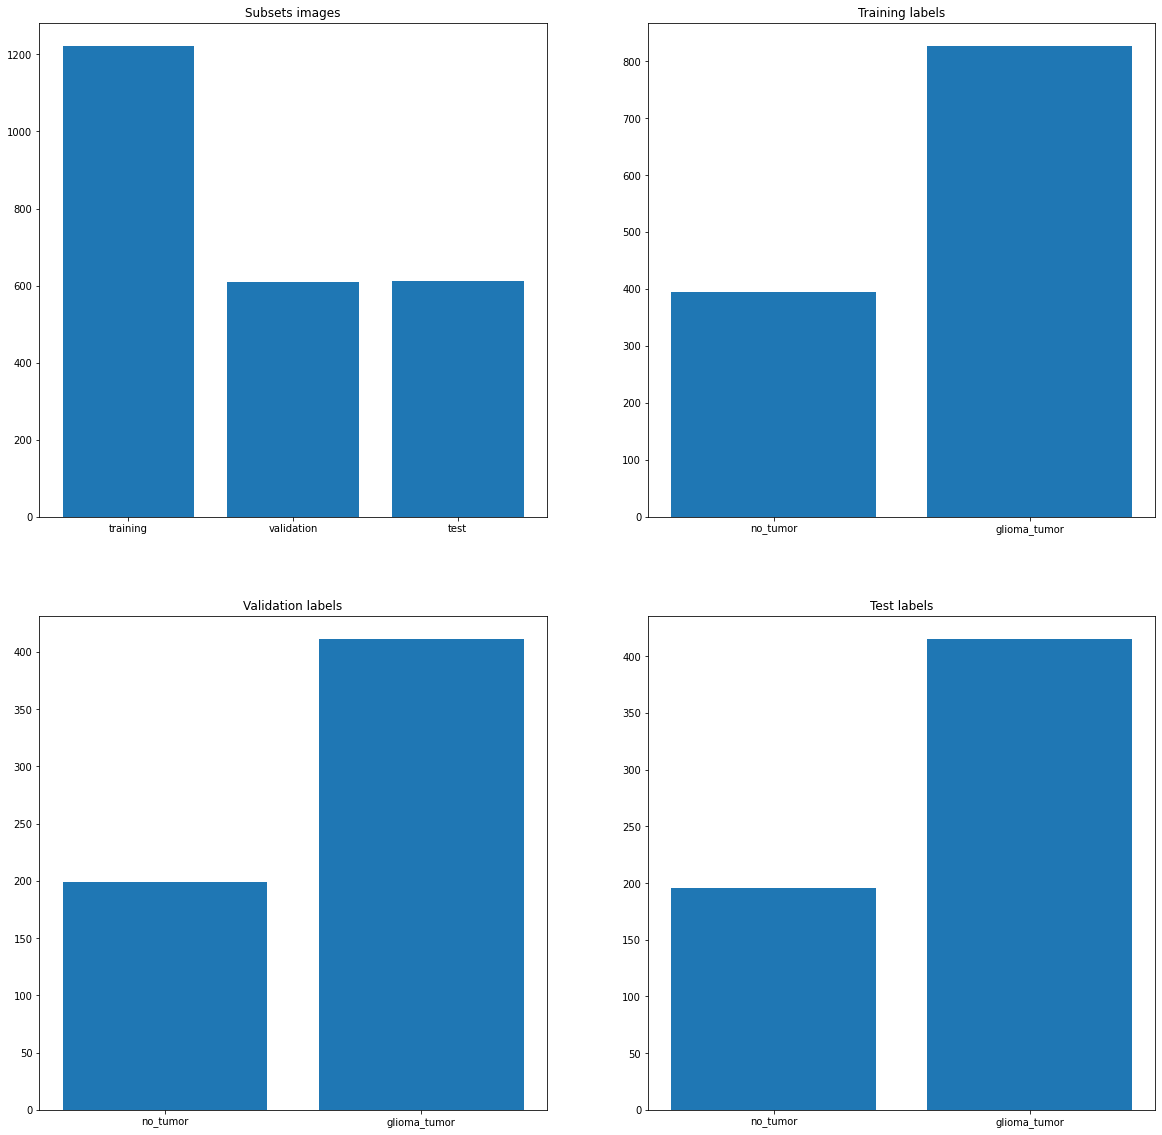

In [13]:
plt.rcParams["figure.figsize"] = (20,20)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.set_title('Subsets images')
ax2.set_title('Training labels')
ax3.set_title('Validation labels')
ax4.set_title('Test labels')

labels = ['training', 'validation', 'test']
shapes = [x_train.shape[0],x_valid.shape[0],x_test.shape[0]]
ax1.bar(labels,shapes)

ax2.bar(categories_selected,[len(y_train)-np.count_nonzero(y_train),np.count_nonzero(y_train)])

ax3.bar(categories_selected,[len(y_valid)-np.count_nonzero(y_valid),np.count_nonzero(y_valid)])

ax4.bar(categories_selected,[len(y_test)-np.count_nonzero(y_test),np.count_nonzero(y_test)])

plt.show()

# Defining the metrics for the model.

There are many metrics that are used in statistics to measure the performance of a model, for this exercise we take the most important and widely used in medicine.

1) the accuracy is the most popular for classification<a href="#11">[11]</a> , it is defined as:
$$\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$$


2) Sensitivity (True Positive rate) measures the proportion of positives that are correctly identified (i.e. the proportion of those who have some condition (affected) who are correctly identified as having the condition).
$$\text{Sensitivity} = \frac{TP}{TP+FN}$$

3) Specificity (True Negative rate) measures the proportion of negatives that are correctly identified (i.e. the proportion of those who do not have the condition (unaffected) who are correctly identified as not having the condition).
$$\text{Sensitivity} = \frac{TN}{TN+FP}$$


4) Receiver operating characteristics (ROC), are commonly used in medical decision making <a href="#12">[12]</a> 
let's take a look for a simple explanetion <a href="https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc">here</a>

Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.



The AUC (Area Under the Curve) for ROC and the precision are defined by default in the tensorflow metrics, the sensitivity and specificity are not, for that we define them in functions that will be called in the training phase by tensorflow.


In [14]:
def sensitivity_caller():
    _tp = tf.keras.metrics.TruePositives()
    _fn = tf.keras.metrics.FalseNegatives()
    @tf.function
    def sensitivity(y_true, y_pred):
        tp = _tp(y_true, y_pred)
        fn = _fn(y_true, y_pred)
        return tp/(tp+fn+K.epsilon())
    return sensitivity

def specificity_caller():
    _tn = tf.keras.metrics.TrueNegatives()
    _fp = tf.keras.metrics.FalsePositives()
    @tf.function
    def specificity(y_true, y_pred):
        tn = _tn(y_true, y_pred)
        fp = _fp(y_true, y_pred)
        return tn/(tn+fp+K.epsilon())
    return specificity

metrics = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.AUC(name='auc'), #ROC
  sensitivity_caller(),
  specificity_caller()
]

2021-07-15 09:18:39.441868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Machine Learning model

The next step is to define the ML model using tensorflow, for this we are using a specialized architecture for image processing with convolutional neural networks. [Good explanation here](https://confusedcoders.com/data-science/deep-learning/cnn-with-tensorflow-for-deep-learning-beginners)

<img src="http://rpmarchildon.com/wp-content/uploads/2018/06/RM-CNN-Schematic-1.jpg" style="width:60%"/>

Convolutional neural networks are a set of layers that allow you to apply filters to images to identify patterns.
In order to define the model we need to define a Sequential object in tensorflow, with this object we are adding several layers defining the procedures throughout the sequence, the layers are the following:

* Conv2D: Perform convolution for 2D images, in our case, images of 64x64 with one channel
<img src="https://miro.medium.com/max/700/1*ulfFYH5HbWpLTIfuebj5mQ.gif"/>

* Activation funciton, Rectified Linear Unit (ReLU): modifies the output of the node.  [https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7]:
<img src="https://miro.medium.com/max/1400/1*DfMRHwxY1gyyDmrIAd-gjQ.png" style="width:50%"/>

* AveragePooling2D:  is a pooling operation that calculates the average value of the patches. [https://paperswithcode.com/method/average-pooling]
<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-05-24_at_1.51.40_PM.png" style="width:20%"/>


images taken from <a href="#13">[13]</a>


In [15]:
model = Sequential()

#hyperparameters
dropout = 0.2
n_filter = 2
img_size=(64,64,1)
optimizer_lr = 1e-3
dense_neurons = 8


model.add(Conv2D(2*n_filter, kernel_size=16, activation=tf.nn.relu, input_shape=img_size))
model.add(Conv2D(4*n_filter, kernel_size=8))
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

model.add(Conv2D(4*n_filter, kernel_size=8))
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

model.add(Conv2D(8*n_filter, kernel_size=4))
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

model.add(Flatten())
model.add(Dense(dense_neurons, activation=tf.nn.relu))
model.add(Dropout(dropout))
model.add(Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer=Adam(optimizer_lr),
              loss='binary_crossentropy',metrics = metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 4)         1028      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 8)         2056      
_________________________________________________________________
activation (Activation)      (None, 42, 42, 8)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 21, 21, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         4104      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 8)           0

# Train the model

The next step is to train the model.
There is some parameters we need to provide in order to train the model.

* **x_(train/valid)**: arrays with images
* **y_(train/valid)**: labels to let know to the model if the image is tumor or not (0: no tumor, 1: glioma)
* **batch size**: the images are processed by batches this means how many images by batch. (the number images affect the RAM memory or the video memory if you are in a GPU accelerator)
* **epochs**: number of times we will pass the information through the model to train it.

the fit method returns the history of the traning, this allow to know more information about the training process and make some plots.


In [16]:
epochs = 20
batch_size = 10
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                    batch_size=batch_size, epochs=epochs)

2021-07-15 09:18:42.332993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-15 09:18:42.350347: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


Epoch 1/20
123/123 [==============================] - 5s 35ms/step - loss: 0.6285 - accuracy: 0.6798 - auc: 0.5917 - sensitivity: 0.9819 - specificity: 0.0211 - val_loss: 0.5876 - val_accuracy: 0.7787 - val_auc: 0.9223 - val_sensitivity: 0.9069 - val_specificity: 0.2746
Epoch 2/20
123/123 [==============================] - 4s 33ms/step - loss: 0.4854 - accuracy: 0.7715 - auc: 0.8234 - sensitivity: 0.8780 - specificity: 0.4086 - val_loss: 0.5031 - val_accuracy: 0.8541 - val_auc: 0.9012 - val_sensitivity: 0.8899 - val_specificity: 0.4467
Epoch 3/20
123/123 [==============================] - 4s 32ms/step - loss: 0.4870 - accuracy: 0.7961 - auc: 0.8399 - sensitivity: 0.8880 - specificity: 0.4949 - val_loss: 0.4270 - val_accuracy: 0.8279 - val_auc: 0.9231 - val_sensitivity: 0.8820 - val_specificity: 0.5358
Epoch 4/20
123/123 [==============================] - 4s 32ms/step - loss: 0.4274 - accuracy: 0.8280 - auc: 0.8764 - sensitivity: 0.8748 - specificity: 0.5763 - val_loss: 0.3446 - val_acc

# Plotting the results of the training

The next step is to make some useful plots to understand what happened in the training process.

the plots will show information about the train and validation dataset, for the loss funciton and multiple matrics surch as accuracy, sensitivity and specificity.


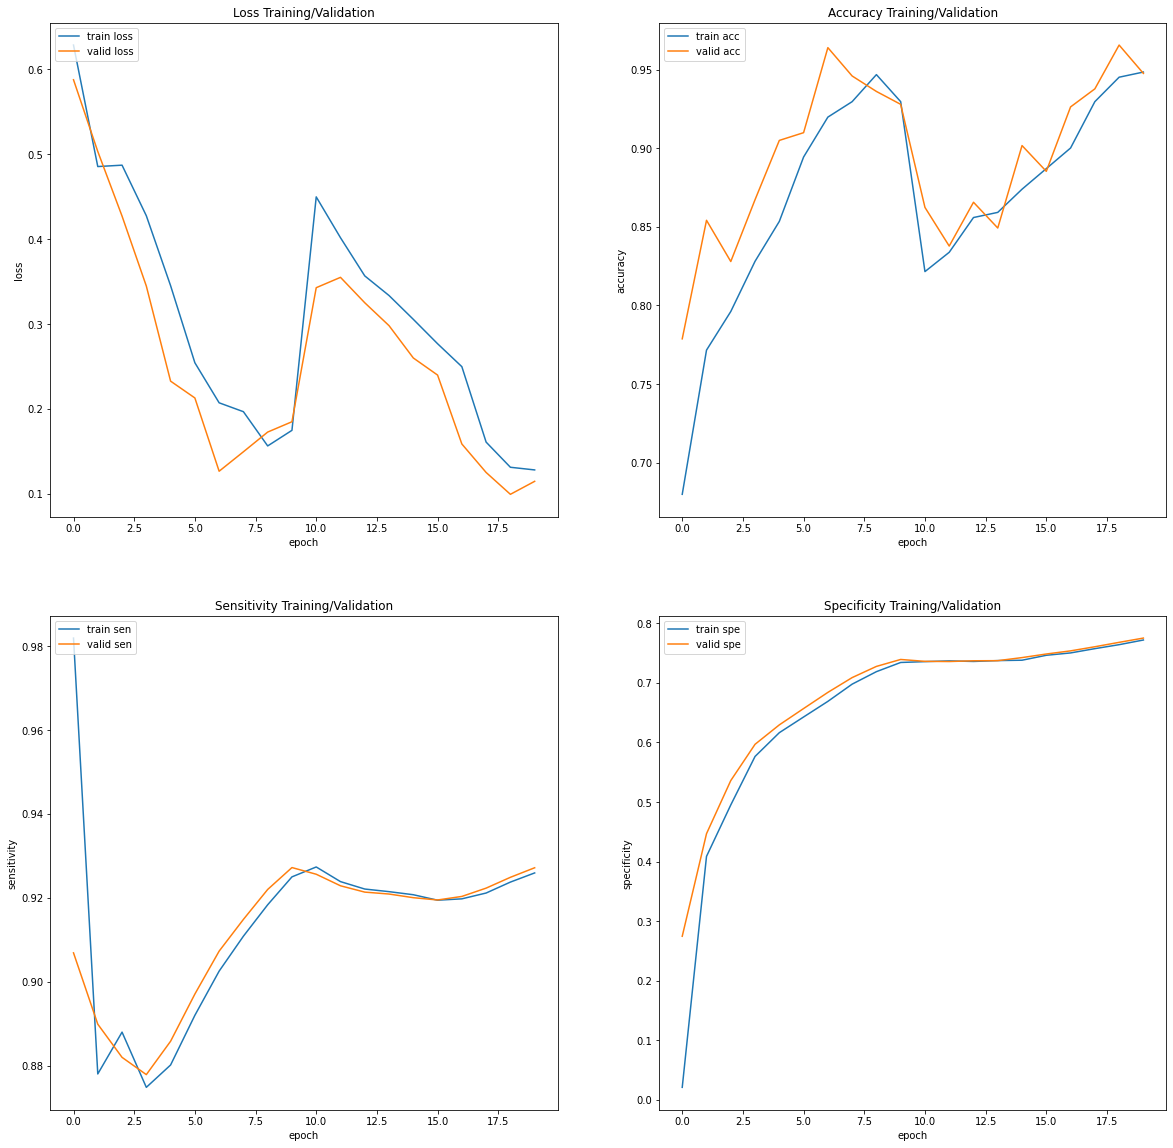

In [17]:
# list all data in history
#print(history.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.set_title('Loss Training/Validation')
ax2.set_title('Accuracy Training/Validation')
ax3.set_title('Sensitivity Training/Validation')
ax4.set_title('Specificity Training/Validation')

# summarize history for accuracy
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])

ax3.plot(history.history['sensitivity'])
ax3.plot(history.history['val_sensitivity'])

ax4.plot(history.history['specificity'])
ax4.plot(history.history['val_specificity'])

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

ax3.set_xlabel('epoch')
ax3.set_ylabel('sensitivity')

ax4.set_xlabel('epoch')
ax4.set_ylabel('specificity')


ax1.legend(['train loss', 'valid loss'], loc='upper left')
ax2.legend(['train acc','valid acc'], loc='upper left')
ax3.legend(['train sen','valid sen'], loc='upper left')
ax4.legend(['train spe','valid spe'], loc='upper left')


plt.show()

# Analysis with the testing subset

Let's validate the models with the testing subset, for this we are going to **make predictions** over the model with the test subset and we are going to plot the **confusion matrix**, **calculate ROC, sensitivity** and **specificity**. 

In [18]:
y_pred = model.predict_classes(x_test)

/home/ozapatam/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


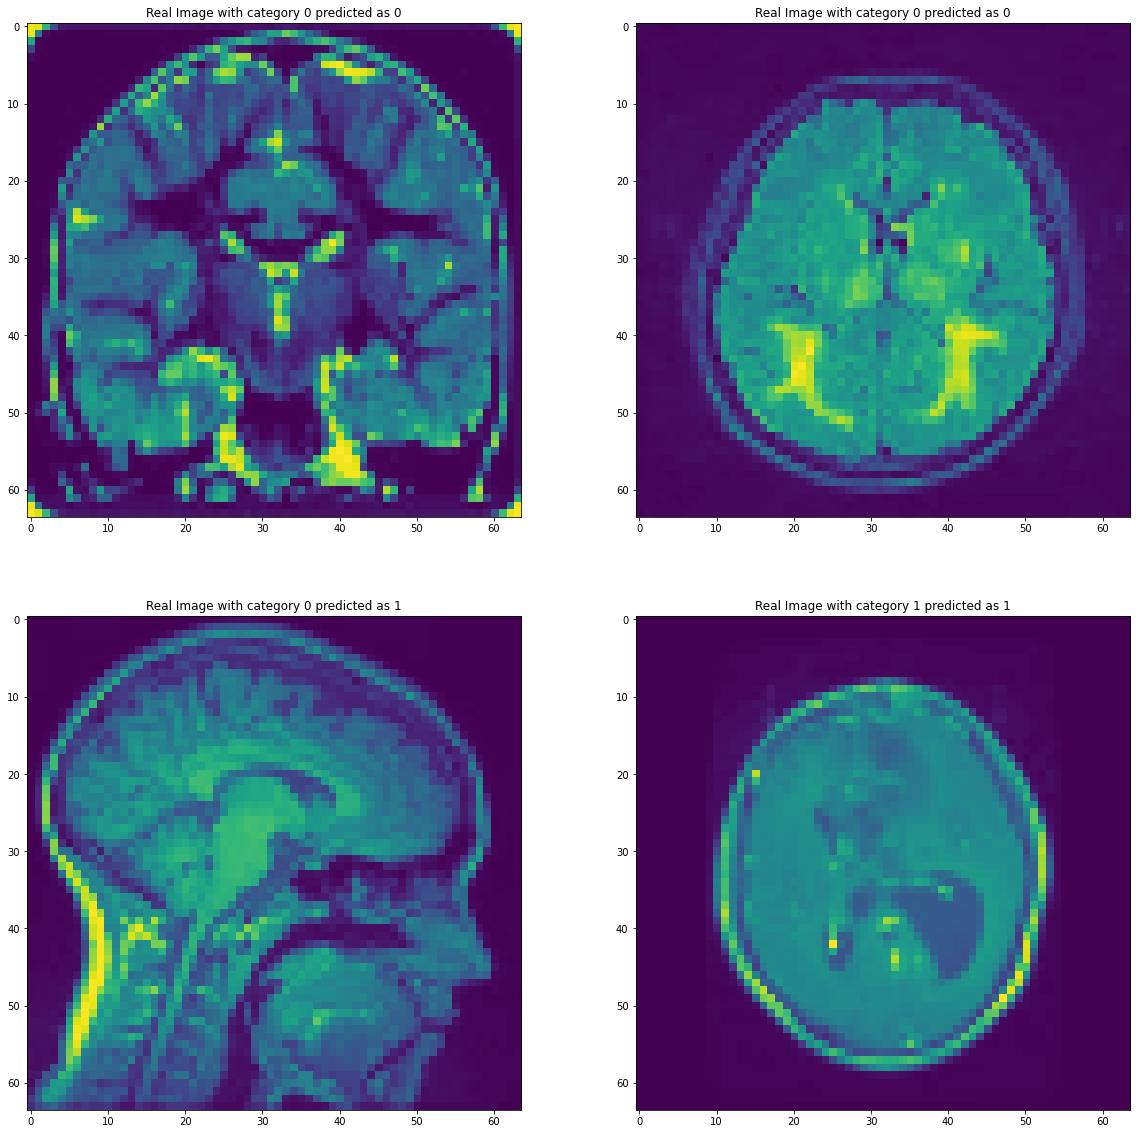

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.set_title('Real Image with category {} predicted as {}'.format(y_test[0], y_pred[0][0]))
ax1.imshow(x_test[0,:,:,0])

ax2.set_title('Real Image with category {} predicted as {}'.format(y_test[1], y_pred[1][0]))
ax2.imshow(x_test[1,:,:,0])

ax3.set_title('Real Image with category {} predicted as {}'.format(y_test[2], y_pred[2][0]))
ax3.imshow(x_test[2,:,:,0])

ax4.set_title('Real Image with category {} predicted as {}'.format(y_test[3], y_pred[3][0]))
ax4.imshow(x_test[3,:,:,0])

plt.show()

# Analysing the confusion matrix

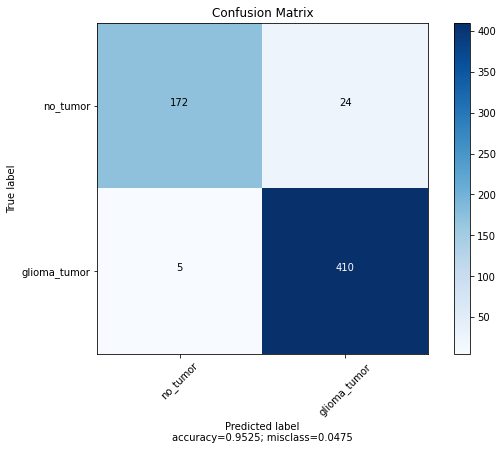

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
plot_confusion_matrix(cm           = confusion_matrix(y_test, y_pred), 
                      normalize    = False,
                      target_names = categories_selected,
                      title        = "Confusion Matrix")

# Sensitivity and specificity

Remember!
* Sensitivity (True Positive rate) measures the proportion of positives that are correctly identified (i.e. the proportion of those who have some condition (affected) who are correctly identified as having the condition).
* Specificity (True Negative rate) measures the proportion of negatives that are correctly identified (i.e. the proportion of those who do not have the condition (unaffected) who are correctly identified as not having the condition).


**Sensitivity** = TP / (TP + FN) 

**Specificity** = TN / (TN + FP)

In [24]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity = {sensitivity} ")
print(f"Specificity = {specificity} ")

Sensitivity = 0.9879518072289156 
Specificity = 0.8775510204081632 



## References
<a id="1">[1] </a> https://www.aans.org/en/Patients/Neurosurgical-Conditions-and-Treatments/Brain-Tumors

<a id="2">[2] </a> https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

<a id="3">[3] </a>https://www.mdpi.com/2076-3417/10/6/1999

<a id="4">[4] </a>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4879034/

<a id="5">[5] </a>https://github.com/ANTsX/ANTs

<a id="6">[6] </a>https://scikit-image.org/

<a id="7">[7] </a>https://opencv.org/

<a id="8">[8] </a>https://www.tensorflow.org/

<a id="9">[9] </a>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

<a id="10">[10] </a>https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

<a id="11">[11] </a>https://developers.google.com/machine-learning/crash-course/classification/accuracy

<a id="12">[12] </a> https://people.inf.elte.hu/kiss/11dwhdm/roc.pdf

<a id="13">[13] </a>https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

### Come back to the index

Lets come back to the index to continue with the exercises!
* [Index](index.ipynb)